In this notebook, we will be going through the following;

* Accessing well data from the OpendTect database with odpy.wellman
* Data Preparation

    * Extracting suitable wells for model training
    * Filling missing data
* Model Training
* Evaluating predictions made

wellman is a python module in OpendTect that allows for the wells database. It contains a list of methods for loading well logs data, information on the wells database etc. The include .getLogs(), .getLogNames(), .getWellDBList(), .getTrack(), getMarkers(), amongst others which will also be explored in this notebook

In [1]:
import odpy.wellman as wmn

In [2]:
wmn

<module 'odpy.wellman' from 'C:\\PROGRA~1\\OPENDT~1\\6683E8~1.0\\bin\\python\\odpy\\wellman.py'>

Numpy and pandas will also be used in this notebook to perform some numerical and data analysis

In [3]:
import pandas as pd
import numpy as np

### PROBLEM DEFINITION

A key aspect of this tutorial is finding the best and most suited wells in the database to train machine learning models for a given test well/log prediction. With a large and different number of wells in the database, it is imperative to find the best set of data for model training to obtain optimal machine learning prediction results.

### APPROACH

The proposed solution is to compare wells in the database with provided test well to get train wells similar to test well that will yield optimal prediction results. This comparison is done statistically to get data with similar statistical distribution. The deciles was employed to this.

#### Example of computed deciles for a given set of data.
Slide 5 of the presentation gives more explanation on this.

![Deciles.jpg](images/deciles.png)

While similar statistical computations like the quartiles, percentiles are readily available in pandas, the deciles are not built in pandas or other open source libraries. So these values are manually computed making use of the functions below.

![Decile-Formula.jpg](images/Decile-Formula.jpg)

In [4]:
def nth_decile(points, n):
    
    '''
    Child function to compute each (nth) decile
    '''
    
    decile = (n * (points + 1))/10
    
    return decile


def compute_deciles(data):
    
    '''
    Function to compute deciles
    
    Arguments
    ---------
    
    data: dataframe object
    
    Returns
    -------
    
    dataframe of computed deciles
    '''
    
    columns = list(data.columns)
    results = pd.DataFrame(columns=columns)
    deciles = ['1st decile', '2nd decile', '3rd decile', '4th decile', '5th decile',
                '6th decile', '7th decile', '8th decile', '9th decile']
    
    results['stat'] = deciles
    
    for idx, column in enumerate(columns):
        values = sorted(list(data[column]))
        decile_positions = [] 
        sorted_data = data.sort_values(by=column)
        n = 0
        
        decile_means = []
        
        for i in range(1, 10):
            
            decile_position = int(nth_decile(len(values), i))
            decile_positions.append(decile_position)
            if n == 0:
                decile_mean = (sorted_data.iloc[n:decile_positions[(i-1)]][column].sum())/(sorted_data.iloc[n:decile_positions[(i-1)]].shape[0])
            else:
                decile_mean = (sorted_data.iloc[decile_positions[(i-2)]:decile_positions[(i-1)]][column].sum())/(sorted_data.iloc[decile_positions[(i-2)]:decile_positions[(i-1)]]).shape[0]
            n += 1
            decile_means.append(decile_mean)
            if len(decile_means) == 9:
                results[column] = decile_means
            
    return results

## Accessing well data from the OpendTect database with odpy.wellman

In [5]:
db = wmn.getWellDBList(reload=True)   # method to get information on chosen survey well database

In [6]:
db

{'Size': 108,
 'IDs': ['100050.2',
  '100050.3',
  '100050.4',
  '100050.5',
  '100050.11',
  '100050.12',
  '100050.6',
  '100050.7',
  '100050.8',
  '100050.9',
  '100050.10',
  '100050.13',
  '100050.14',
  '100050.15',
  '100050.16',
  '100050.17',
  '100050.18',
  '100050.19',
  '100050.20',
  '100050.21',
  '100050.22',
  '100050.23',
  '100050.24',
  '100050.25',
  '100050.26',
  '100050.27',
  '100050.28',
  '100050.29',
  '100050.30',
  '100050.31',
  '100050.32',
  '100050.33',
  '100050.34',
  '100050.35',
  '100050.36',
  '100050.37',
  '100050.38',
  '100050.39',
  '100050.40',
  '100050.41',
  '100050.42',
  '100050.43',
  '100050.44',
  '100050.45',
  '100050.46',
  '100050.47',
  '100050.48',
  '100050.49',
  '100050.50',
  '100050.51',
  '100050.52',
  '100050.53',
  '100050.54',
  '100050.55',
  '100050.56',
  '100050.57',
  '100050.58',
  '100050.59',
  '100050.60',
  '100050.61',
  '100050.62',
  '100050.63',
  '100050.64',
  '100050.65',
  '100050.66',
  '100050.67

In [7]:
db.keys()

dict_keys(['Size', 'IDs', 'Names', 'Status'])

Checking out the well names from the survey database. The current wells are from the 2020 FORCE survey 

In [10]:
db_wellnames = db['Names']
db_wellnames

['15/9-13',
 '15/9-14',
 '15/9-15',
 '15/9-17',
 '16/1-2',
 '16/1-6 A',
 '16/10-1',
 '16/10-2',
 '16/10-3',
 '16/10-5',
 '16/11-1 ST3',
 '16/2-11 A',
 '16/2-16',
 '16/2-6',
 '16/4-1',
 '16/5-3',
 '16/7-4',
 '16/7-5',
 '16/8-1',
 '17/11-1',
 '25/10-10',
 '25/11-15',
 '25/11-19 S',
 '25/11-24',
 '25/11-5',
 '25/2-13 T4',
 '25/2-14',
 '25/2-7',
 '25/3-1',
 '25/4-5',
 '25/5-1',
 '25/5-3',
 '25/5-4',
 '25/6-1',
 '25/6-2',
 '25/6-3',
 '25/7-2',
 '25/8-5 S',
 '25/8-7',
 '25/9-1',
 '26/4-1',
 '29/3-1',
 '29/6-1',
 '30/3-3',
 '30/3-5 S',
 '30/6-5',
 '31/2-1',
 '31/2-19 S',
 '31/2-7',
 '31/2-8',
 '31/2-9',
 '31/3-1',
 '31/3-2',
 '31/3-3',
 '31/3-4',
 '31/4-10',
 '31/4-5',
 '31/5-4 S',
 '31/6-5',
 '31/6-8',
 '32/2-1',
 '33/5-2',
 '33/6-3 S',
 '33/9-1',
 '33/9-17',
 '34/10-16 R',
 '34/10-19',
 '34/10-21',
 '34/10-33',
 '34/10-35',
 '34/11-1',
 '34/11-2 S',
 '34/12-1',
 '34/2-4',
 '34/3-1 A',
 '34/3-3 A',
 '34/4-10 R',
 '34/5-1 A',
 '34/5-1 S',
 '34/6-1 S',
 '34/7-13',
 '34/7-20',
 '34/7-21',
 '34/

In [11]:
len(db['Names'])  # checking the number of available wells

108

Making use of the .getLogNames() method to get the available log names for a particular well (well 15/9-14). This information is needed to extract the corresponding data for these logs.

In [15]:
lognames = wmn.getLogNames(wllnm='15/9-14')

In [16]:
lognames

['CALI',
 'MUDWEIGHT',
 'ROP',
 'RDEP',
 'RSHA',
 'RMED',
 'RXO',
 'SP',
 'DTC',
 'NPHI',
 'PEF',
 'GR',
 'RHOB',
 'DRHO',
 'DEPTH_MD',
 'x_loc',
 'y_loc',
 'z_loc']

The .getLogs() method is used to get the well logs data, and takes in the well name and available log names as arguments. 

In [17]:
depth, data = wmn.getLogs(wllnm='15/9-14', lognames=lognames)

In [18]:
data.head()

,CALI,MUDWEIGHT,ROP,RDEP,RSHA,RMED,RXO,SP,DTC,NPHI,PEF,GR,RHOB,DRHO,DEPTH_MD,X_LOC,Y_LOC,Z_LOC
0,19.2031,0.130611,96.461990,1.513937,NaN,1.613886,NaN,35.525719,174.347092,0.551575,55.815659,72.078377,2.171173,-0.538873,480.628001,423244.50000,6461862.5,-455.624420
1,19.2031,0.130611,96.454399,1.480188,NaN,1.574376,NaN,36.158520,176.112915,0.547566,41.862537,72.147697,2.171840,-0.539232,480.780001,423244.50000,6461862.5,-455.776428
2,19.2031,0.130611,96.446686,1.469700,NaN,1.436627,NaN,36.873703,177.662476,0.551840,38.587872,75.074219,2.161303,-0.540830,480.932001,423244.50000,6461862.5,-455.928436
3,19.2031,0.130611,161.170166,1.469341,NaN,1.276094,NaN,37.304054,177.437714,0.552511,41.417999,80.735229,2.151947,-0.543943,481.084001,423244.50000,6461862.5,-456.080444
4,19.2031,0.130611,172.489120,1.466462,NaN,1.204704,NaN,37.864922,176.797653,0.566789,49.471237,81.665024,2.143010,-0.542104,481.236001,423244.53125,6461862.5,-456.232422


An example of the computed deciles making use of the compute_deciles function is illustrated below. The first 9 deciles are computed and the last is left out. This is to prevent any form of outlier data from interferring with the results. The stats column presents information on the deciles computed

In [20]:
compute_deciles(data)

,CALI,MUDWEIGHT,ROP,RDEP,RSHA,RMED,RXO,SP,DTC,NPHI,PEF,GR,RHOB,DRHO,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,stat
0,8.715523,0.129542,2.902616,0.411408,1.190557,0.482127,1.190561,22.523850,65.951246,0.127559,1.652555,14.803136,1.828850,-0.067381,634.680001,423237.848234,6.461837e+06,-3384.210227,1st decile
1,10.159723,0.130611,5.258246,0.588222,9.143177,0.625410,16.456168,27.960249,78.188366,0.203039,1.948127,25.574369,1.967599,-0.020509,942.936001,423239.122735,6.461848e+06,-3076.663101,2nd decile
2,12.159608,0.134321,7.512609,0.712924,0.000000,0.722520,0.000000,30.503313,90.820853,0.283477,2.127973,33.547559,2.018083,-0.007564,1252.488498,423240.625092,6.461855e+06,-2768.710596,3rd decile
3,12.877682,0.136184,10.723160,0.805626,0.000000,0.815827,0.000000,32.424282,109.029135,0.367144,2.264087,42.715395,2.044786,0.001311,1560.816001,423242.307661,6.461859e+06,-2460.576590,4th decile
4,13.585502,0.140352,15.829974,0.908898,0.000000,0.946928,0.000000,33.499349,126.206699,0.412368,2.492070,50.982812,2.071734,0.007884,1869.148001,423244.072111,6.461860e+06,-2152.274611,5th decile
5,14.186536,0.145127,21.827803,1.126425,0.000000,1.114576,0.000000,34.553118,136.377282,0.443974,2.827241,58.232344,2.112484,0.014220,2177.480001,423244.883352,6.461863e+06,-1843.990339,6th decile
6,14.939911,0.147836,27.732620,1.383962,0.000000,1.302952,0.000000,35.869237,142.005996,0.466291,3.381695,64.267181,2.187231,0.025374,2485.736001,423245.454651,6.461864e+06,-1535.763064,7th decile
7,17.259441,0.149783,33.177826,1.675657,0.000000,1.566705,0.000000,38.096188,146.810223,0.484875,4.380926,69.742083,2.287240,0.039973,2793.992001,423247.030464,6.461865e+06,-1227.453897,8th decile
8,17.872046,0.158796,43.935435,2.435448,0.000000,2.564115,0.000000,42.362689,152.307462,0.505385,3.439572,75.813618,2.457385,0.057946,3102.248001,423256.348696,6.461866e+06,-917.919189,9th decile


Observation from the computed deciles shows values of zeros from the 3rd to 9th deciles for both RSHA and RXO logs. This is as a result of missing values present in these logs. This implies that percentage of missing data in a well should also have an effect on the choice of data selected for model training.

In [22]:
(data.isna().sum()/data.shape[0]) * 100    # percentage of missing values of each logs

CALI          0.000000
MUDWEIGHT     0.059169
ROP           0.108476
RDEP          0.000000
RSHA         80.267245
RMED          0.108476
RXO          80.217938
SP            0.000000
DTC           0.285982
NPHI          0.000000
PEF          17.686505
GR            0.000000
RHOB          0.000000
DRHO          0.000000
DEPTH_MD      0.000000
X_LOC         0.000000
Y_LOC         0.000000
Z_LOC         0.000000
dtype: float64

## Data Preparation

### Extracting suitable wells for model training

This is done by comparing the comouted deciles of the test well and train wells. This comparison is done by using evaluaion metircs; root mean squared error (rmse) and coefficient of determination (r2 score) of computed deciles. The aim is to find wells in the database that have the least rmse of the computed deciles with that of a particular test well. The r2 score is not used in this example. Future notebook or workflow could incorporate this second metric as well.

![RMSE.jpg](images/RMSE.jpg)

**Slide 8 of the presentation shows and describes the residuals for a set of predictions and actual values**

In [23]:
def check_full_corr(train, test):
    
    '''
    Function to compare computed deciles of two dataframes (train and test wells)
    
    Arguments
    ---------
    
    Returns
    -------
    
    dataframe of rmse of both dataframes
    '''
    
    columns = list(test.columns)
    columns.remove('stat')
    results = pd.DataFrame(index=['RMSE', 'R2'], columns=columns)
    
    for idx, column in enumerate(columns):
        if (column in list(train.columns)) and (column in list(test.columns)):
            rmse = sklm.mean_squared_error(test[column], train[column]) ** 0.5
            r2 = sklm.r2_score(test[column], train[column])
            results[column] = rmse, r2
        
        # if log in test is not in train data, set log values=0
        elif column not in list(train.columns):
            train[column] = 0
            rmse = sklm.mean_squared_error(test[column], train[column]) ** 0.5
            r2 = sklm.r2_score(test[column], train[column])
            results[column] = rmse, r2
        
    return results

In [24]:
import sklearn.metrics as sklm   # sklearn metrics module
from sklearn.preprocessing import StandardScaler    # StandardScaler for standardizing evaluation results

Below, we have the main function that uses previously defined functions (for computing the deciles and making comparisons). This function takes in a list of well names available and the test dataset, and loops through the database to compare the computed deciles for each of the wells with that of the particular test data (well). It returns a table of all wells in the database and the rmse evaluation of the computed deciles of each well with that of the test well. 

In [25]:
def find_suitable_wells(trainwells, testwell):
    
    '''
    Main function to find most suited training wells
    based on computed statistics (rmse score)
    
    Arguments
    ---------
    trainwells -> list: name list of available wells in the database
    testwell -> pd.dataframe: test dataframe to be predicted
    
    Returns
    ------
    
    Dataframe of wells with rmse of deciles with test well data
    '''
    
    columns = list(testwell.columns)
    columns.remove('X_LOC')
    columns.remove('Y_LOC')
    columns.remove('Z_LOC')
    columns.remove('DEPTH_MD')
    testwell = testwell.drop(['X_LOC', 'Y_LOC', 'Z_LOC', 'DEPTH_MD'], axis=1)
    test_deciles = compute_deciles(testwell)  # calculate the test deciles
    
    df = pd.DataFrame(columns= (['well'] + columns))
    sum_df = pd.DataFrame(columns=['well', 'rmse'])   # final result dataframe
    df['well'] = trainwells
    
    # loop through database to compute each well deciles
    for i, well in enumerate(trainwells):
        
        logs = wmn.getLogNames(well)
        depth, welldata = wmn.getLogs(well, logs[2:-4])
        train_deciles = compute_deciles(welldata)  # calculate train well deciles
        
        result = check_full_corr(train_deciles, test_deciles)   # correlate/evaluate train and test deciles
        df.iloc[i].well = well
        
        for log in list(result.columns):   # append each log computed rmse to result
            df.iloc[i][log] = result.iloc[0][log]
    
    wells = []
    rmses = []
    
    scaled_df = pd.DataFrame(columns=df.columns)
    
    # compute the normalized rmse of logs using StandardScaler
    for log in columns:
        scaler = StandardScaler()
        data = scaler.fit_transform(np.array(df[log]).reshape(-1, 1))
        scaled_df[log] = data.flatten()
    
    for i, well in enumerate(trainwells):
        
        rmse_ = 0
        
        df_ = scaled_df.drop('well', axis=1)
        for log in columns:
            df_ = df_.drop(log, axis=1, inplace=False)
            rmse = (df_.iloc[i].sum()/4)
            rmse_ += rmse
            
        rmses.append(rmse_)
        wells.append(well)
    
    scaled_df['well'] = wells
        
    sum_df['well'] = wells   # sum_df = result dataframe with summed up rmse of all logs for each wells
    sum_df['rmse'] = rmses   # scaled df =  dataframe of normalized rmses of logs
    
    return df, sum_df, scaled_df

A test well is chosen below; well 34/10-16 R and its data is loaded from the database as previously shown with wellman

In [26]:
# getting test data

test_logs = list(wmn.getLogNames('34/10-16 R'))

In [27]:
depth, testdata= wmn.getLogs('34/10-16 R', test_logs)

In [28]:
train_wells = db['Names']

In [29]:
train_wells

['15/9-13',
 '15/9-14',
 '15/9-15',
 '15/9-17',
 '16/1-2',
 '16/1-6 A',
 '16/10-1',
 '16/10-2',
 '16/10-3',
 '16/10-5',
 '16/11-1 ST3',
 '16/2-11 A',
 '16/2-16',
 '16/2-6',
 '16/4-1',
 '16/5-3',
 '16/7-4',
 '16/7-5',
 '16/8-1',
 '17/11-1',
 '25/10-10',
 '25/11-15',
 '25/11-19 S',
 '25/11-24',
 '25/11-5',
 '25/2-13 T4',
 '25/2-14',
 '25/2-7',
 '25/3-1',
 '25/4-5',
 '25/5-1',
 '25/5-3',
 '25/5-4',
 '25/6-1',
 '25/6-2',
 '25/6-3',
 '25/7-2',
 '25/8-5 S',
 '25/8-7',
 '25/9-1',
 '26/4-1',
 '29/3-1',
 '29/6-1',
 '30/3-3',
 '30/3-5 S',
 '30/6-5',
 '31/2-1',
 '31/2-19 S',
 '31/2-7',
 '31/2-8',
 '31/2-9',
 '31/3-1',
 '31/3-2',
 '31/3-3',
 '31/3-4',
 '31/4-10',
 '31/4-5',
 '31/5-4 S',
 '31/6-5',
 '31/6-8',
 '32/2-1',
 '33/5-2',
 '33/6-3 S',
 '33/9-1',
 '33/9-17',
 '34/10-16 R',
 '34/10-19',
 '34/10-21',
 '34/10-33',
 '34/10-35',
 '34/11-1',
 '34/11-2 S',
 '34/12-1',
 '34/2-4',
 '34/3-1 A',
 '34/3-3 A',
 '34/4-10 R',
 '34/5-1 A',
 '34/5-1 S',
 '34/6-1 S',
 '34/7-13',
 '34/7-20',
 '34/7-21',
 '34/

The test well is removed from the list of wells to find the most suited train wells from

In [30]:
print(len(train_wells))
train_wells.remove('34/10-16 R')
print(len(train_wells))

108
107


The find_suitable_wells function returns three dataframes;

* The first is a dataframe of all the wells and test logs and the evaluated rmse of the deciles for each of the wells.
* The second is a dataframe of all the wells and the summation of the rmse (scaled rmse) of all logs present
* The third is a dataframe of the scaled rmse from the first dataframe. The scaled rmse is computed and used to avoid/prevent a single log with an outlier value affecting the final summation (the second dataframe)

In [31]:
results, sum_results, scaled_Df = find_suitable_wells(train_wells, testdata)

In [32]:
results

,well,CALI,RDEP,RSHA,RMED,RXO,SP,DTC,NPHI,PEF,GR,RHOB,DRHO
0,15/9-13,1.082693,0.639772,2.654635,1.090863,2.981439,17.622182,13.459858,0.152840,3.157421,13.407732,0.117637,0.020461
1,15/9-14,13.939745,0.807654,3.774710,1.178264,5.805126,31.200816,8.659463,0.240274,4.432403,5.574449,0.083488,0.021318
2,15/9-15,0.777733,0.871803,1.479042,1.290440,511.016641,12.061891,15.035172,0.132690,3.874069,9.641495,0.087803,0.016155
3,15/9-17,1.016958,0.640977,2.420079,1.114112,23.810272,31.109655,13.662646,0.190466,3.502917,6.506041,0.077251,0.027912
4,16/1-2,4.697014,0.703089,3.219771,3.238441,2.577853,25.053155,47.479309,0.242277,7.044186,51.780255,0.257547,0.030855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,35/9-6 S,3.417063,4.489907,2.577853,3.123977,2.577853,64.587626,26.235299,0.192337,6.753506,36.786502,0.342610,0.029736
103,35/9-8,5.734794,6.106208,2.577853,5.903768,2.577853,64.587626,38.734356,0.189848,4.118949,40.147212,0.369093,0.034974
104,36/7-3,13.939745,5.421898,2.577853,4.962039,2.577853,64.587626,32.568835,0.184216,4.981838,39.904157,0.393480,2.506940
105,7/1-1,2.017540,1.262965,2.577853,1.645338,2.577853,64.587626,76.292277,0.266320,7.044186,9.204490,1.883942,0.038326


In [33]:
scaled_Df

,well,CALI,RDEP,RSHA,RMED,RXO,SP,DTC,NPHI,PEF,GR,RHOB,DRHO
0,15/9-13,-0.913444,-0.119237,-0.174712,-0.236387,-0.162386,-0.972513,-0.529599,-0.822119,-0.771216,-0.653445,-0.586102,-0.229084
1,15/9-14,2.140933,-0.115806,-0.141521,-0.218246,-0.136207,-0.631774,-0.740295,0.579374,-0.356154,-1.059161,-0.649213,-0.226251
2,15/9-15,-0.985891,-0.114496,-0.209548,-0.194963,4.547622,-1.112041,-0.460456,-1.145107,-0.537916,-0.848513,-0.641238,-0.243316
3,15/9-17,-0.929060,-0.119212,-0.181662,-0.231561,0.030719,-0.634062,-0.520698,-0.219005,-0.658742,-1.010911,-0.660740,-0.204454
4,16/1-2,-0.054810,-0.117943,-0.157966,0.209355,-0.166127,-0.786042,0.963562,0.611476,0.494095,1.334019,-0.327531,-0.194726
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,35/9-6 S,-0.358881,-0.040565,-0.176987,0.185598,-0.166127,0.206025,0.031133,-0.189027,0.399466,0.557433,-0.170325,-0.198425
103,35/9-8,0.191729,-0.007538,-0.176987,0.762559,-0.166127,0.206025,0.579734,-0.228920,-0.458197,0.731498,-0.121382,-0.181113
104,36/7-3,2.140933,-0.021521,-0.176987,0.567098,-0.166127,0.206025,0.309121,-0.319200,-0.177289,0.718909,-0.076311,7.989899
105,7/1-1,-0.691358,-0.106503,-0.176987,-0.121302,-0.166127,0.206025,2.228204,0.996868,0.494095,-0.871147,2.678238,-0.170032


In [34]:
sum_results

,well,rmse
0,15/9-13,-9.013507
1,15/9-14,-6.626502
2,15/9-15,-5.073872
3,15/9-17,-8.026600
4,16/1-2,4.050703
...,...,...
102,35/9-6 S,0.929547
103,35/9-8,0.969897
104,36/7-3,23.372348
105,7/1-1,10.228248


With these resukts we can see how the wells in the database compares with the test well with the method. the sum_results summarises the effects of each log comparison as a summation. Now we can sort this result (rmse) ascendingly to see the wells with the least rmse (estimated to represent wells with the most similar comparison with the particular test well).

In [35]:
sorted_sum_result = sum_results.sort_values('rmse')
sorted_sum_result.head(30)

,well,rmse
82,34/8-1,-11.147720
66,34/10-21,-10.303922
27,25/2-7,-9.517247
26,25/2-14,-9.160461
0,15/9-13,-9.013507
18,16/8-1,-8.808345
92,35/11-7,-8.804133
3,15/9-17,-8.026600
7,16/10-2,-7.226118
1,15/9-14,-6.626502


Since top wells (wells with the least rmse) in this results are estimated to be the most similar wells and hence suitable wells for training and making predictions on the test well, these wells can now be used for training the model. Wells with the highest rmse (appearing at the bottom of this sorted result), should have a worse performance if trained to predict the test logs.

Three different train data samples are created below from the top wells in this result. Each sample composed of three wells from the top result.

In [37]:
df = sorted_sum_result.copy()

In [38]:
def get_well_data(rmse_df, columns):
    
    '''
    Function to get best top 9 performing data 
    from database 
    
    Arguments
    ---------
    
    Sorted rmse dataframe
    
    Returns
    --------
    
    A list of the top 9 wells dataframes
    '''
    
    train = pd.DataFrame(columns=columns[:-3])
    traina = train.copy()
    trainb = train.copy()
    trainc = train.copy()
    traind = train.copy()
    traine = train.copy()
    trainf = train.copy()
    traing = train.copy()
    trainh = train.copy()
    traini = train.copy()
    
    trainwells__ = [traina, trainb, trainc, traind, traine, trainf, traing, trainh, traini]
    trainwells___ = []
    
    for i, k in enumerate(trainwells__):
        well = rmse_df.iloc[i].well
        depth,  j = wmn.getLogs(well, (wmn.getLogNames(well)[2:-3]))
        trainwells___.append(j)
        
        if i > 7 :
            break
        
    return (trainwells___)

In [39]:
traindata = get_well_data(df, list(testdata.columns))

In [40]:
len(traindata)

9

In [41]:
# creating three different train data sets from the top wells

train1 = pd.concat((traindata[0], traindata[1], traindata[2]))   # top 1-3
train2 = pd.concat((traindata[3], traindata[4], traindata[5]))   # top 4-6
train3 = pd.concat((traindata[6], traindata[7], traindata[8]))   # top 7-9

In [42]:
# checking the size of the created train data

train1.shape, train2.shape, train3.shape

((65499, 16), (40795, 17), (32792, 19))

In [43]:
train1

,CALI,RDEP,RSHA,RMED,SP,DTC,NPHI,PEF,GR,RHOB,DRHO,DEPTH_MD,RXO,BS,MUDWEIGHT,ROP
924195,NaN,2.448344,NaN,2.342517,40.925129,129.312363,NaN,35.829308,69.968681,2.220934,-0.722545,891.137023,NaN,NaN,NaN,NaN
924196,NaN,2.476600,NaN,2.310889,41.105415,130.909302,NaN,52.217407,70.798073,2.244186,-0.698928,891.289023,NaN,NaN,NaN,NaN
924197,NaN,2.476006,NaN,2.320935,41.069263,128.291702,NaN,47.126434,70.503883,2.265586,-0.684372,891.441023,NaN,NaN,NaN,NaN
924198,NaN,2.456676,NaN,2.275842,40.739120,129.663040,NaN,32.226471,74.514320,2.306645,-0.661161,891.593023,NaN,NaN,NaN,NaN
924199,NaN,2.444762,NaN,2.223282,40.348568,130.931213,NaN,34.626266,70.679718,2.304855,-0.662985,891.745023,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288170,10.388752,3.559378,4.725739,4.725739,94.045380,85.566734,0.294375,5.089154,96.602898,2.351417,0.284717,4019.490001,NaN,8.5,NaN,NaN
288171,10.602076,3.520222,4.781342,4.781342,93.956276,85.712906,0.288024,5.064764,96.130997,2.346393,0.278687,4019.642001,NaN,8.5,NaN,NaN
288172,10.624195,3.480923,4.785402,4.785402,93.831573,85.995491,0.287371,5.060152,96.809807,2.338805,0.270805,4019.794001,NaN,8.5,NaN,NaN
288173,10.643840,3.486869,4.567891,4.567891,93.819000,86.896248,0.289109,5.039681,96.398674,2.331720,0.262823,4019.946001,NaN,8.5,NaN,NaN


In [44]:
test_logs = wmn.getLogNames(wllnm='34/10-16 R', reload=True)
test_logs

['CALI',
 'RDEP',
 'RSHA',
 'RMED',
 'RXO',
 'SP',
 'DTC',
 'NPHI',
 'PEF',
 'GR',
 'RHOB',
 'DRHO',
 'DEPTH_MD',
 'x_loc',
 'y_loc',
 'z_loc']

The coordinates columns (x_loc, y_loc, and z_loc) were dropped from the list of logs for training the machine learning

In [46]:
test_logs = test_logs[:-3]
test_logs

['CALI',
 'RDEP',
 'RSHA',
 'RMED',
 'RXO',
 'SP',
 'DTC',
 'NPHI',
 'PEF',
 'GR',
 'RHOB',
 'DRHO',
 'DEPTH_MD']

Getting the test data from the database

In [48]:
depth, test = wmn.getLogs('34/10-16 R', test_logs)

### Filling missing data

Checking the percentage of missing values in the test logs

In [51]:
(test.isna().sum()/test.shape[0]) * 100

CALI         0.139470
RDEP         0.000000
RSHA         0.573819
RMED         0.119546
RXO          0.573819
SP           0.000000
DTC          0.270970
NPHI        33.767683
PEF          0.789002
GR           0.000000
RHOB         0.000000
DRHO         9.511855
DEPTH_MD     0.000000
dtype: float64

The function below is used to  resolve missing values. Better tools in the OpendTect software are available for interpolating missing data

In [52]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    The mean value of a log is used for filling up numerical logs while
    the mode is used for categorical columns
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data

In [53]:
train1 = fill_missing_values(train1)
train2 = fill_missing_values(train2)
train3 = fill_missing_values(train3)
test = fill_missing_values(test)

## Model Training

The model is trained with xgboost with a 10 fold cross validation loop as a model ensembling tool for better performance. The KFold CV from sklearn.model_selection module was used and petroeval is used for rendering easy visualizations.

Five logs from the test well are chosen as the test logs; GR, NPHI, RHOB, DTC

In [54]:
import xgboost as xgb
import sklearn.model_selection as ms
!pip3 install petroeval
import petroeval as pet

Defaulting to user installation because normal site-packages is not writeable


In [56]:
class Model():
    
    '''
    Model class for training model
    
    Arguments
    ----------
    
    train: train dataframe
    test: test dataframe
    
    Methods
    --------
    
    _train (for model training)
    predict (for making prediction with trained model)
    evaluate (for evaluting predictions)
    plot_feat_imp (to display feature importance of trained model)
    '''
    
    def __init__(self, train, test):
        
        self.train = train
        self.test = test
        
        train_columns = list(train.columns)
        test_columns = list(test.columns)
        
        unfound_columns = []
        for column in train_columns:
            if column not in test_columns:
                unfound_columns.append(column)
                
                
        # dropping columns in train data set not in test data
        train = train.drop(unfound_columns, axis=1)
        self.train = train
        
        
    def __call__(self, plot=True):
        
        test = self.test
        train = self.train
        
        ntrain = train.shape[0]
        ntest = test.shape[0]
            
        # little preparation to get train and test columns in order
        
        df = pd.concat((train, test))
        train = df[:ntrain]
        test = df[ntrain:]
        
        print(f'train columns: {train.columns}')
        print(f'test columns: {test.columns}')
        
        test_logs = ['GR', 'NPHI', 'RHOB', 'DTC']   # test logs for predictions
        
        results = pd.DataFrame(columns=[test_logs], index=['RMSE', 'R2 Score']) # evaluation table showing rmse and r2 score
        
        # train, predict and evaluation loop
        for log_idx, log in enumerate(test_logs):
            print(f'Experiment {log_idx + 1}, testing for log {log}')
            print('==============================================')
            labels = np.array(test[log])
            model = self._train(self.train, log)
            print('==============================================')
            new_test = test.drop([log], axis=1)
            pred = self.predict(model, new_test)
            rmse, r2_score = self.evaluate(pred, labels, log)
            results[log] = rmse, r2_score
            print('==============================================')
            
        return results
    
    
    def _train(self, train, label, plot=False):
        
        '''
        Method to train model; uses a 10 Fold CV 
        
        Arguments
        ---------
        
        train -> pandas.dataframe: training data
        label -> list or pandas.Series: train target
        
        Returns
        -------
        
        A list of the trained models from CV
        '''
        
        self.train = train
        self.label = label
        self.plot = plot
        
        labels = train[label]
        train = train.drop(label, axis=1)
        
        split = 10
        kf = ms.KFold(n_splits=split, shuffle=False)
        
        model = xgb.XGBRegressor(n_estimators=1500, max_depth=8, n_jobs=-1,
                                 reg_lambda=500, random_state=2021, learning_rate=0.1,
                                 colsample_bytree=0.9, subsample=0.9, tree_method='gpu_hist')
        i = 1
        models = []
        
        for (train_index, test_index) in kf.split(train, labels):
            X_train,X_test = train.iloc[train_index], train.iloc[test_index]
            Y_train,Y_test = labels.iloc[train_index], labels.iloc[test_index]
            print(f'Model {i} training...')
        
            model.fit(X_train, Y_train, early_stopping_rounds=100, 
                      eval_set=[(X_test, Y_test)], verbose=300)
            models.append(model)
            i += 1
        
        return models
    
    
    def predict(self, models, test):
        
        '''
        MEthod for making predictions with trained models from CV loop
        
        Arguments
        ---------
        models: list of pretrained model
        test: test data for predictions
        
        Returns
        -------
        
        Averaged prediction from pretrained models
        '''
        
        self.models = models
        self.test = test
        predictions = np.zeros((len(test)))
        
        for i,model in enumerate(models):
            print(f'Predicting using model {i+1}')
            predictions += model.predict(test)
            
        prediction = predictions/10
        print('prediction complete')
        
        return prediction
    
    
    def evaluate(self, prediction, actual_labels, log_name):
        
        '''
        Method for evaluating predictions. Displays scaled plot of predicted log and actual log
        
        Arguments
        ---------
        prediction: predicted values
        actual_labels: actual log values
        log_name: predicted log name
        
        Returns
        -------
        Rmse and r2 score of predictions
        '''
        
        self.prediction = prediction
        self.actual_labels = actual_labels
        self.log_name = log_name
        
        rmse = sklm.mean_squared_error(actual_labels, prediction) ** 0.5
        r2_score = sklm.r2_score(actual_labels, prediction)
        
        test = self.test
        test['predicted ' + log_name] = prediction
        test[log_name] = actual_labels
        
        pet.two_plot(test, x1=log_name, x2=f'predicted {log_name}', top=test.DEPTH_MD.iloc[0], 
                      base=test.DEPTH_MD.iloc[test.shape[0] - 1], depth='DEPTH_MD', scale=True)
        
        return [rmse, r2_score]
    
    
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

Training and predictions with first sample of train data created

train columns: Index(['CALI', 'RDEP', 'RSHA', 'RMED', 'SP', 'DTC', 'NPHI', 'PEF', 'GR',
       'RHOB', 'DRHO', 'DEPTH_MD', 'RXO'],
      dtype='object')
test columns: Index(['CALI', 'RDEP', 'RSHA', 'RMED', 'SP', 'DTC', 'NPHI', 'PEF', 'GR',
       'RHOB', 'DRHO', 'DEPTH_MD', 'RXO'],
      dtype='object')
Experiment 1, testing for log GR
Model 1 training...
[0]	validation_0-rmse:76.68404
[257]	validation_0-rmse:37.46654
Model 2 training...
[0]	validation_0-rmse:66.84331
[300]	validation_0-rmse:16.88359
[433]	validation_0-rmse:16.93869
Model 3 training...
[0]	validation_0-rmse:70.61913
[300]	validation_0-rmse:28.29203
[600]	validation_0-rmse:26.43196
[900]	validation_0-rmse:25.82430
[1040]	validation_0-rmse:25.86901
Model 4 training...
[0]	validation_0-rmse:31.12829
[116]	validation_0-rmse:10.64297
Model 5 training...
[0]	validation_0-rmse:46.15638
[176]	validation_0-rmse:10.43123
Model 6 training...
[0]	validation_0-rmse:80.39150
[298]	validation_0-rmse:38.72209
Model 7 training...
[0]	v

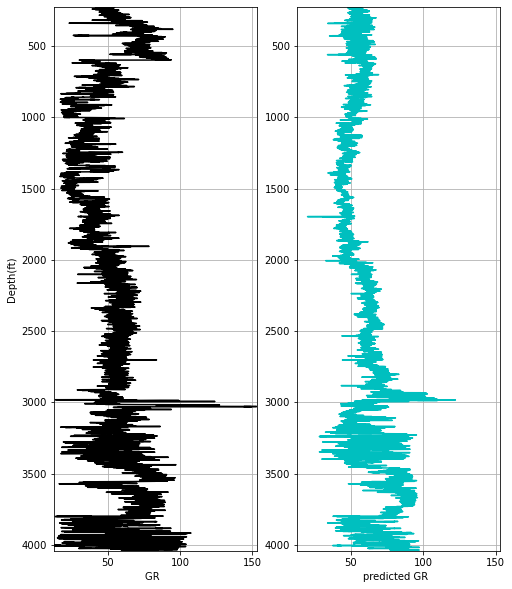

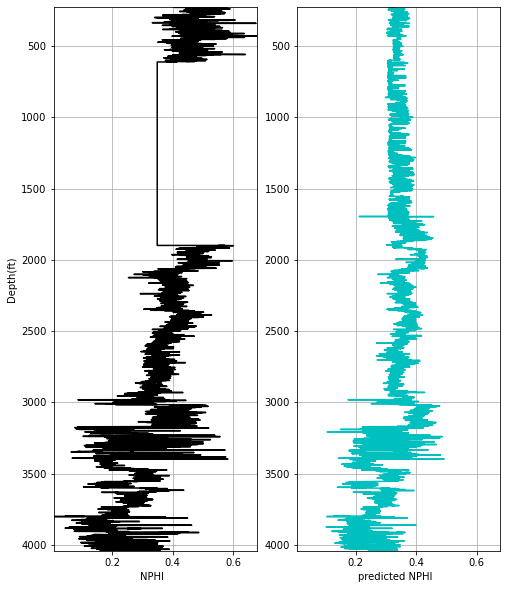

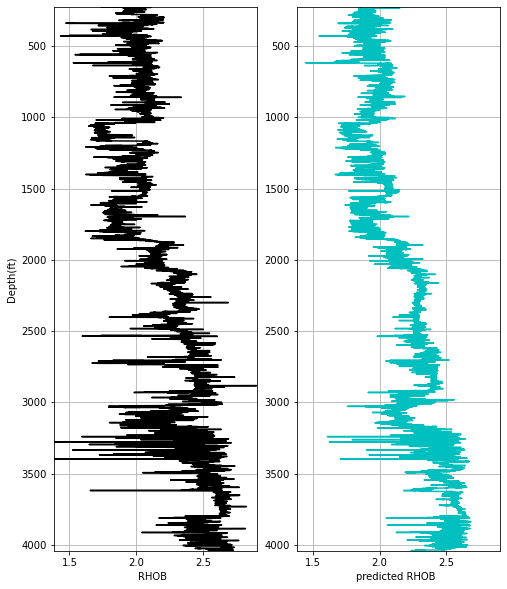

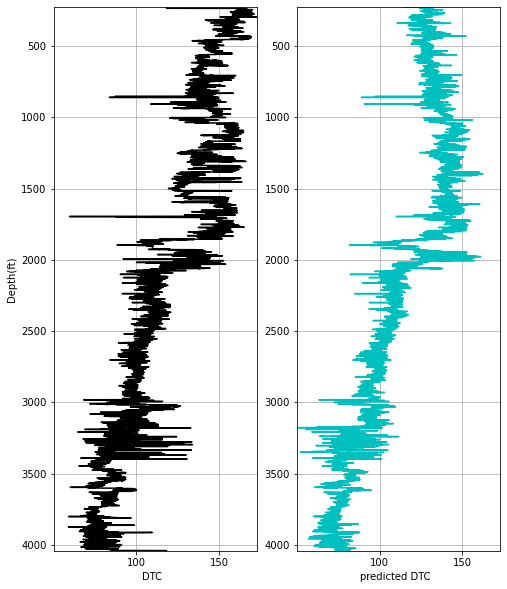

In [55]:
model = Model(train1, test)
results = model()

Training and predictions with second sample of train data created

train columns: Index(['CALI', 'RDEP', 'RSHA', 'RMED', 'SP', 'DTC', 'NPHI', 'PEF', 'GR',
       'RHOB', 'DRHO', 'DEPTH_MD', 'RXO'],
      dtype='object')
test columns: Index(['CALI', 'RDEP', 'RSHA', 'RMED', 'SP', 'DTC', 'NPHI', 'PEF', 'GR',
       'RHOB', 'DRHO', 'DEPTH_MD', 'RXO'],
      dtype='object')
Experiment 1, testing for log GR
Model 1 training...
[0]	validation_0-rmse:46.93513
[122]	validation_0-rmse:10.40303
Model 2 training...
[0]	validation_0-rmse:44.20842
[300]	validation_0-rmse:7.48431
[600]	validation_0-rmse:7.36949
[822]	validation_0-rmse:7.35655
Model 3 training...
[0]	validation_0-rmse:61.91435
[168]	validation_0-rmse:30.93935
Model 4 training...
[0]	validation_0-rmse:81.37661
[277]	validation_0-rmse:40.00346
Model 5 training...
[0]	validation_0-rmse:54.64525
[300]	validation_0-rmse:12.97147
[542]	validation_0-rmse:12.83821
Model 6 training...
[0]	validation_0-rmse:66.97832
[139]	validation_0-rmse:15.26625
Model 7 training...
[0]	validation_0-rmse:50.26041
[128]	valid

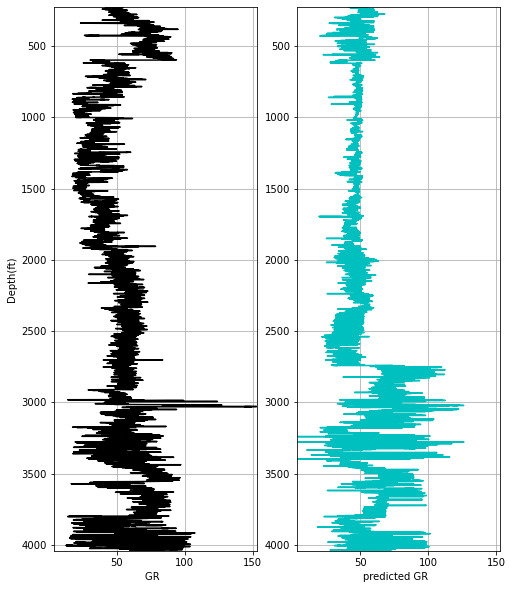

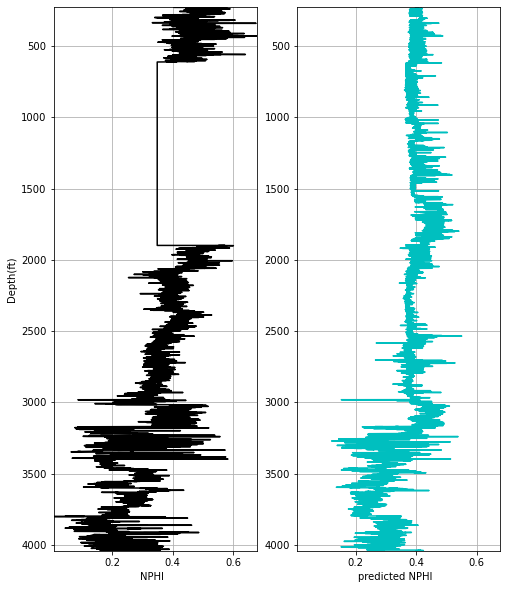

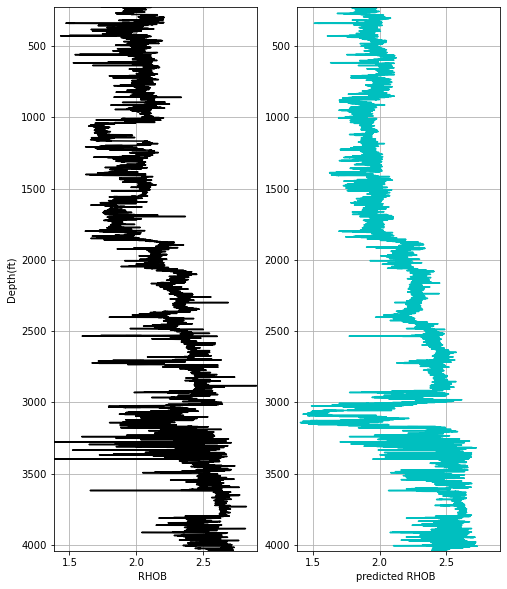

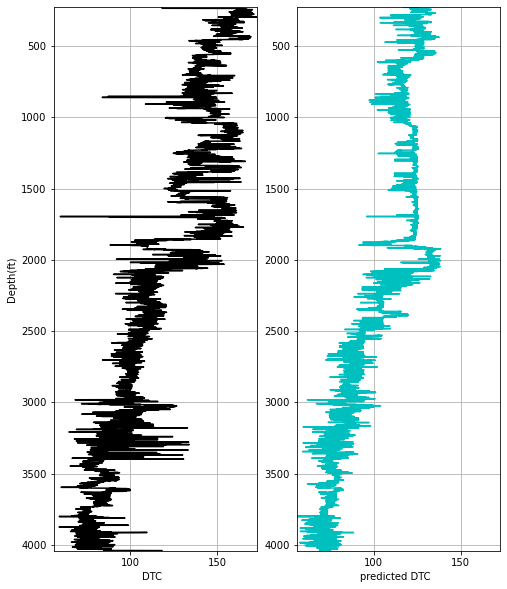

In [57]:
model2 = Model(train2, test)
results2 = model2()

Training and predictions with third sample of train data created

train columns: Index(['CALI', 'RDEP', 'RSHA', 'RMED', 'SP', 'DTC', 'NPHI', 'PEF', 'GR',
       'RHOB', 'DRHO', 'DEPTH_MD', 'RXO'],
      dtype='object')
test columns: Index(['CALI', 'RDEP', 'RSHA', 'RMED', 'SP', 'DTC', 'NPHI', 'PEF', 'GR',
       'RHOB', 'DRHO', 'DEPTH_MD', 'RXO'],
      dtype='object')
Experiment 1, testing for log GR
Model 1 training...
[0]	validation_0-rmse:58.97928
[158]	validation_0-rmse:18.89068
Model 2 training...
[0]	validation_0-rmse:54.63721
[236]	validation_0-rmse:13.71780
Model 3 training...
[0]	validation_0-rmse:75.57168
[151]	validation_0-rmse:8.72781
Model 4 training...
[0]	validation_0-rmse:62.34007
[175]	validation_0-rmse:17.69093
Model 5 training...
[0]	validation_0-rmse:54.29633
[300]	validation_0-rmse:11.57244
[301]	validation_0-rmse:11.57290
Model 6 training...
[0]	validation_0-rmse:56.44147
[145]	validation_0-rmse:14.63135
Model 7 training...
[0]	validation_0-rmse:56.23901
[211]	validation_0-rmse:9.48789
Model 8 training...
[0]	validation_0-rmse:3

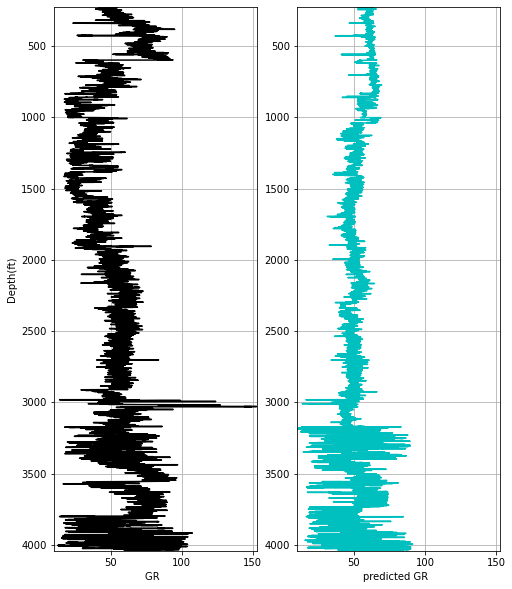

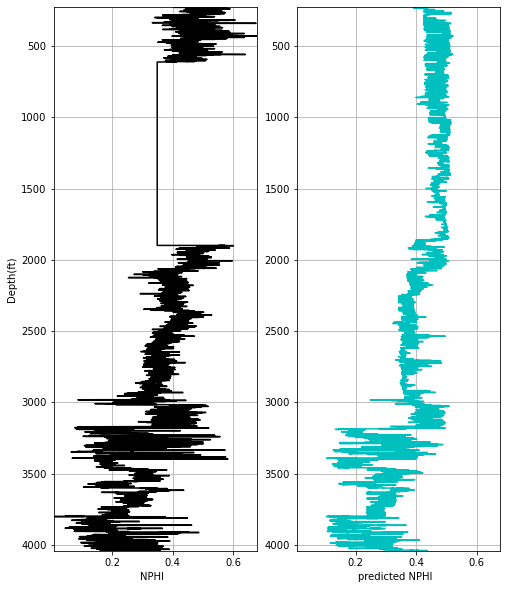

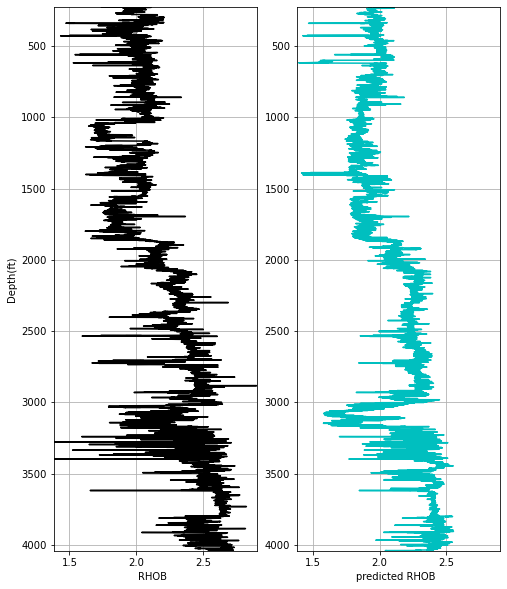

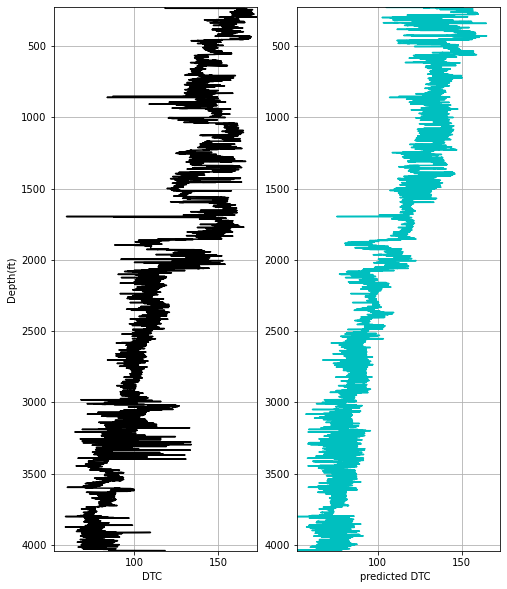

In [59]:
model3 = Model(train3, test)
results3 = model3()

## Evaluating predictions made

Predictions are evaluated with actual test logs below making use of the rmse and r2 scores. Plots of the predicted and actual logs are also shown above

In [56]:
results 

,GR,NPHI,RHOB,DTC
RMSE,15.324798,0.063620,0.112365,11.830622
R2 Score,0.217787,0.471047,0.810390,0.817768


In [58]:
results2

,GR,NPHI,RHOB,DTC
RMSE,16.942979,0.079322,0.153619,19.299261
R2 Score,0.043874,0.177722,0.645603,0.515058


In [60]:
results3

,GR,NPHI,RHOB,DTC
RMSE,17.464460,0.089485,0.168749,17.435456
R2 Score,-0.015888,-0.046494,0.572353,0.604201
